In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf
import numpy as np
# matlabのファイルを扱うためのライブラリ
from scipy.io import loadmat

In [2]:
# matlab形式: {R, G, B, index}
trainset = loadmat("data/test_32x32.mat")
testset = loadmat("data/train_32x32.mat")

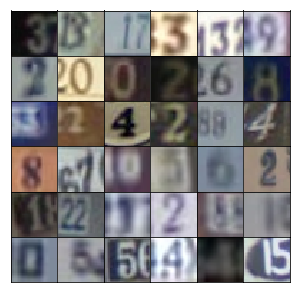

In [3]:
"""データをランダムに取り出して表示する"""
# ランダムな整数を生成, 36枚
idx = np.random.randint(0, trainset["X"].shape[3], size=36)
# 図全体と部分的な図, 縦横6枚ずつ, 5*5
fig, axes = plt.subplots(6, 6, figsize=(5, 5), sharex=True, sharey=True, facecolor="w")
for ii, ax in zip(idx, axes.flatten()):
    # ii番目の画像データの表示, 縦横の比率を同じにする
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [4]:
def scale(x, feature_ranges=(-1, 1)):
    """データの正規化"""
    # [0, 255] -> [0, 1]
    x = (x - x.min()) / (255 - x.min())
    min, max = feature_ranges
    # [0, 1] -> [-1, 1]
    x = x * (max - min) + min
    return x

In [5]:
# データセットのクラスを定義する
class Dataset:
    """
    val_frac: test dataをtrainとvalで分離する割合
    scale_func: データのスケールを別に用意するか
    """

    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        # test dataをtestとvalに分割する
        split_index = int(len(test["y"]) * (1 - val_frac))
        # test用とval用の入力データ
        self.test_x, self.valid_x = (
            test["X"][:, :, :, :split_index],
            test["X"][:, :, :, split_index:],
        )
        # test用とval用の教師データ
        self.test_y, self.valid_y = (
            test["y"][:split_index],
            test["y"][split_index:],
        )
        # train用の入力データと教師データ
        self.train_x, self.train_y = train["X"], train["y"]

        # Tensorflow形式に変換: {index, R, G, B}
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)

        # データ正規化関数の指定
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func

        self.shuffle = shuffle

    def batches(self, batch_size):
        """ミニバッチを生成する関数"""
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        # バッチ取得回数
        n_batches = len(self.train_y) // batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii : ii + batch_size]
            y = self.train_y[ii : ii + batch_size]

            yield self.scaler(x), y

In [6]:
def model_inputs(real_dim, z_dim):
    """変数（プレースホルダ）を初期化する関数"""
    # 変動するマーク *
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")

    return inputs_real, inputs_z

In [7]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    """generate fake data using CNN"
    deconvolution: 畳み込み（圧縮）と逆の処理, データを大きくする
    """
    with tf.variable_scope("generator", reuse=reuse):
        # fully-connected
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        # 1次元にreshape, 可変長の4*4*512
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        # データの偏りを調整する処理
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        
        # 畳み込み
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # -> 8 * 8 * 256

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # -> 16 * 16 * 128

        # score, fully-connected
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding="same")
        # -> 32 * 32 * 3
        
        # [-1, 1]: 画像
        out = tf.tanh(logits)

        return out

In [8]:
def discriminator(x, reuse=False, alpha=0.2):
    """discriminator using CNN
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # 32 * 32 * 3
        # 畳み込み
#         x1 = tf.layers.conv2d_transpose(x, 64, 5, strides=2, padding="same")
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding="same")
        x1 = tf.maximum(alpha * x1, x1)
        # -> 16 * 16 * 64

#         x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # -> 8 * 8 * 128
        
#         x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding="same")
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # -> 4 * 4 * 256

        # score, fully-connected
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

In [9]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """損失関数の定義"""
    # fake dataの作成
    g_model = generator(input_z, output_dim, alpha=alpha)

    # real dataの識別結果
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)

    # fake dataの識別結果
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    # 1 - smoothとの誤差, realをrealと見抜く
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)
        )
    )

    # 0との誤差, fakeをfakeと見抜く
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )

    # discriminator loss
    d_loss = d_loss_real + d_loss_fake

    # 正解1との誤差, fakeをrealに近づけられたか
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        )
    )
    
    return d_loss, g_loss

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """最適化"""
    # weight, biasなどのパラメータをまとめて取り出す関数
    t_vars = tf.trainable_variables()
    # 分割
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            d_loss, var_list=d_vars
        )
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(
            g_loss, var_list=g_vars
        )
    return d_train_opt, g_train_opt

In [11]:
class GAN:
    def __init__(self, real_size, z_size, learing_rate, alpha=0.2, beta1=0.5):
        """モデルの定義"""
        # グラフの初期化
        tf.reset_default_graph()

        # 入力データ定義
        self.input_real, self.input_z = model_inputs(real_size, z_size)

        # lossの定義
        self.d_loss, self.g_loss = model_loss(
            self.input_real, self.input_z, real_size[2], alpha=alpha
        )

        # 最適化の定義
        self.d_opt, self.g_opt = model_opt(
            self.d_loss, self.g_loss, learning_rate, beta1
        )

In [12]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5, 5)):
    """イメージに変換して表示する"""
    # 画像と軸を描画する
    fig, axes = plt.subplots(
        figsize=figsize,
        nrows=nrows,
        ncols=ncols,
        sharey=True,
        sharex=True,
        facecolor="w",
    )
    for ax, img in zip(axes.flatten(), samples[epoch]):
        # 軸の設定
        ax.axis("off")
        # 正規化
        img = ((img - img.min()) * 255 / (img.max() - img.min())).astype(np.uint8)
        # 四角形
        ax.set_adjustable("box-forced")
        # 縦横比が同じ
        im = ax.imshow(img, aspect="equal")

    # 余白の設定
    plt.subplots_adjust(wspace=0, hspace=0)

    return fig, axes

In [13]:
def train(
    net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5, 5)
):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    # session開始
    with tf.Session() as sess:
        # 変数の初期化
        sess.run(tf.global_variables_initializer())
        # エポックを回す
        for e in range(epochs):
            # 1epochで学習標本全てを用いる
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Generatorにおけるfake画像生成, 一様分布
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # discriminatorの最適化
                _ = sess.run(
                    net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z}
                )
                # generatorの最適化
                _ = sess.run(
                    net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x}
                )

                # loss
                if steps % print_every == 0:
                    train_loss_d = net.d_loss.eval(
                        {net.input_z: batch_z, net.input_real: x}
                    )
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    print(
                        "エポック: {}/{}".format(e + 1, epochs),
                        "D_loss: {:.4f}".format(train_loss_d),
                        "G_loss: {:.4f}".format(train_loss_g),
                    )

                    # loss追加
                    losses.append((train_loss_d, train_loss_g))

                """fake画像の作成"""
                if steps % show_every == 0:
                    gen_samples = sess.run(
                        generator(net.input_z, 3, reuse=True, training=False),
                        feed_dict={net.input_z: sample_z},
                    )
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        # モデル保存
        saver.save(sess, "./checkpoints/generator.ckpt")

    # samplesのsave
    with open("./samples.pkl", "wb") as f:
        pkl.dump(samples, f)

    return losses, samples

In [14]:
# ハイパーパラメータの設定

real_size = (32, 32, 3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 2
alpha = 0.2
beta1 = 0.5

net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

In [15]:
dataset = Dataset(trainset, testset)

エポック: 1/2 D_loss: 1.5577 G_loss: 0.6315
エポック: 1/2 D_loss: 0.3687 G_loss: 2.2769
エポック: 1/2 D_loss: 0.2827 G_loss: 1.9935
エポック: 1/2 D_loss: 0.1493 G_loss: 2.7949
エポック: 1/2 D_loss: 0.1857 G_loss: 2.6620
エポック: 1/2 D_loss: 0.0755 G_loss: 3.5012
エポック: 1/2 D_loss: 0.2374 G_loss: 2.0054
エポック: 1/2 D_loss: 0.4975 G_loss: 2.0104
エポック: 1/2 D_loss: 0.8367 G_loss: 1.6077
エポック: 1/2 D_loss: 0.7949 G_loss: 2.1532


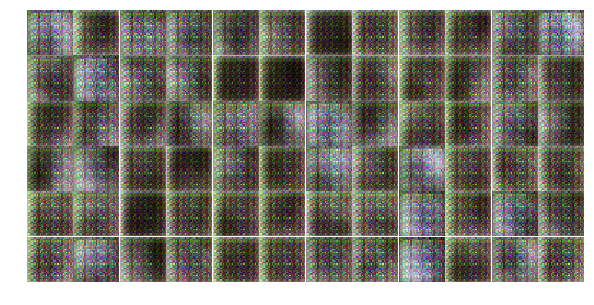

エポック: 1/2 D_loss: 0.5988 G_loss: 1.5640
エポック: 1/2 D_loss: 0.4555 G_loss: 1.7491
エポック: 1/2 D_loss: 0.5042 G_loss: 2.2232
エポック: 1/2 D_loss: 0.4475 G_loss: 2.6642
エポック: 1/2 D_loss: 0.3454 G_loss: 2.5694
エポック: 1/2 D_loss: 0.2696 G_loss: 2.6650
エポック: 1/2 D_loss: 0.3491 G_loss: 2.6231
エポック: 1/2 D_loss: 0.3679 G_loss: 3.3653
エポック: 1/2 D_loss: 0.4110 G_loss: 1.3869
エポック: 1/2 D_loss: 0.1303 G_loss: 5.0835


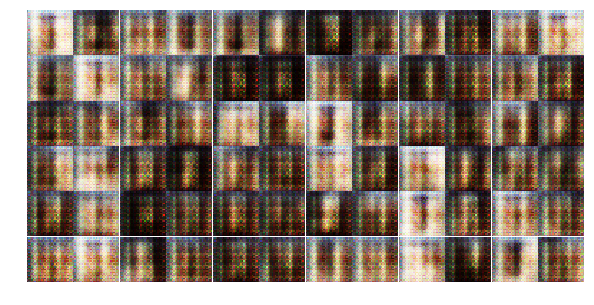

エポック: 2/2 D_loss: 0.2229 G_loss: 4.0246
エポック: 2/2 D_loss: 0.3431 G_loss: 3.0556
エポック: 2/2 D_loss: 0.4764 G_loss: 1.8684
エポック: 2/2 D_loss: 0.5011 G_loss: 1.9005
エポック: 2/2 D_loss: 1.1531 G_loss: 1.1851
エポック: 2/2 D_loss: 1.1017 G_loss: 1.1354
エポック: 2/2 D_loss: 0.5658 G_loss: 1.9469
エポック: 2/2 D_loss: 0.2653 G_loss: 2.9103
エポック: 2/2 D_loss: 0.2452 G_loss: 2.8893
エポック: 2/2 D_loss: 1.3799 G_loss: 0.4147


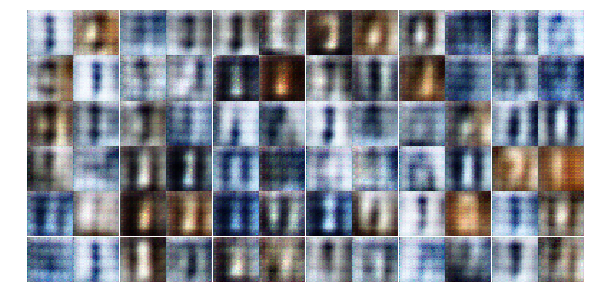

エポック: 2/2 D_loss: 0.3720 G_loss: 2.0797
エポック: 2/2 D_loss: 1.2595 G_loss: 5.2394
エポック: 2/2 D_loss: 0.4517 G_loss: 1.5953
エポック: 2/2 D_loss: 1.2890 G_loss: 0.7855
エポック: 2/2 D_loss: 0.7387 G_loss: 1.7119
エポック: 2/2 D_loss: 0.4628 G_loss: 2.3539
エポック: 2/2 D_loss: 0.5000 G_loss: 1.4412
エポック: 2/2 D_loss: 0.2505 G_loss: 2.5942
エポック: 2/2 D_loss: 1.5636 G_loss: 1.2081
エポック: 2/2 D_loss: 1.1358 G_loss: 0.7537


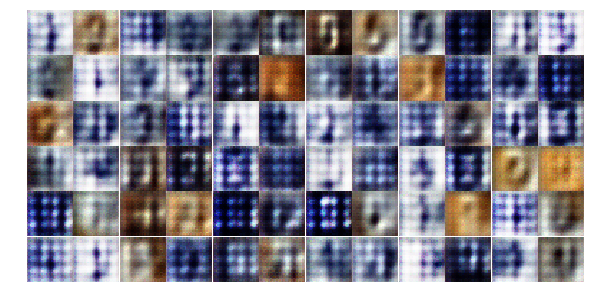

In [16]:
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10, 5))

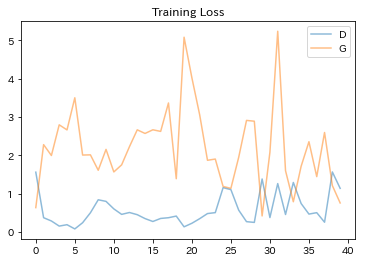

In [17]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='D', alpha=0.5)
plt.plot(losses.T[1], label='G', alpha=0.5)
plt.title('Training Loss')
plt.legend()